In [1]:
import math

In [2]:
# hydraulic functions 
# depth == flow depth          
# bottom == bottom width of trapezoidal channel
# side == side slope (same value both sides) of trapezoidal channel
# computed values:
# bt == computed topwidth :: ar == flow area, used in fd update :: wp == wetted perimeter, used in fd update

def bt(depth,bottom,side):   # depth-topwidth function
    topwidth = (bottom + 2.0*side*depth);
    return(topwidth);

def ar(depth,bottom,side):  # depth area function
    area = (depth*(bottom+side*depth));
    return(area)

def wp(depth,bottom,side):   # depth perimeter
    import math
    perimeter = (bottom+2.0*depth*math.sqrt(1.0+side*side));
    return(perimeter)

In [3]:
###### Problem Constants #######
# these are constants that define the problem
# change for different problems
# a good habit is to assign constants to names so the
# program is readable by people in a few years
g = 9.81 # gravitational acceleration, obviously SI units
n = 10 # number of reaches
q0 = 55.4 # initial discharge
yd = 8.000 # initial flow depth in the model
yu = 5.000 # upstream constant depth
mn = 0.020 # Manning's n
b0 = 5 # bottom width
s0 = 0.001 # longitudinal slope (along direction of flow)
s  = 0.0 # side slope (passed to calls to hydraulic variables)
l  = 11380.0 # total length (the length of computational domain)
tmax = 7000 # total simulation time in seconds
iprt =  31 # print every iprt time steps
nn = n+1 # how many nodes, will jack with boundaries later
mn2 = mn*mn # Manning's n squared, will appear a lot.
a = ar(yd,b0,s) # flow area at beginning of time
v0 = q0/a # initial velocity

In [4]:
######## Here we build storage vectors ###############
y = [0]*nn # create nn elements of vector y, all zero
yp = [0]*nn # updates go in this vector, same length as y
v = [0]*nn # create nn elements of vector v
vp = [0]*nn # updates go in this vector, same length and v
b = [0]*nn
ytmp = [0]*nn
vtmp = [0]*nn
y = [float(yd) for i in y] # populate y with nn things, each thing has value yd
v = [float(v0) for i in y] # populate v with nn things, each thing has value v0

In [5]:
b = bt(y[0],b0,s) # topwidth at downstream end
c = math.sqrt(g*a/b) # celerity at initial conditions
dx = l/n # delta x, length of a reach
#dx

In [6]:
xx = [dx*(i) for i in range(0,nn)] # Spatial locations of nodes, used for plotting

In [7]:
bse = [12 - s0*xx[i] for i in range(0,nn)] # bottom channel elevation
wse = [bse[i]+y[i] for i in range(0,nn)] # water surface elevation
dt = dx/(v0 + c) # the time step that satisfies the courant condtions
kmax = round(tmax/dt)  # set maximum number of time steps

In [8]:
bse

[12.0,
 10.862,
 9.724,
 8.586,
 7.4479999999999995,
 6.31,
 5.172,
 4.034,
 2.895999999999999,
 1.7579999999999991,
 0.6199999999999992]

In [9]:
print('Celerity = ',round(c,3) )
print('Delta x  = ',round(dx,3))
print('Delta t  = ',round(dt,3))
print("ITmax = ",(kmax))

Celerity =  8.859
Delta x  =  1138.0
Delta t  =  111.091
ITmax =  63


In [10]:
# display functions 
import matplotlib

def writenow(t,dt,y,v,b0,s): # printing functions
    print("__________")
    print("Time = ",round(t,3)," seconds.","Time step length = ",round(dt,3)," seconds ")
    print("IROW "," DEPTH "," VELOCITY ")
    for irow in range(0,len(v)):
        print(irow,round(y[irow],3),round(v[irow],3))
    return()  #observe a NULL return, this function messages to the output device, so there is nothing to return.

def plot2lines(list1,list2,list3,list4,strx,stry,strtitle): # plot list1 on x, list2 on y, xlabel, ylabel, title
    from matplotlib import pyplot as plt # import the plotting library from matplotlibplt.show()
    plt.plot( list1, list2, color ='brown', marker ='*', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.plot( list3, list4, color ='blue', marker ='o', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.title(strtitle)# add a title
    plt.ylabel(stry)# add a label to the x and y-axes
    plt.xlabel(strx)
    plt.show() # display the plot
    return #null return

__________
Time =  0.0  seconds. Time step length =  111.091  seconds 
IROW   DEPTH   VELOCITY 
0 8.0 1.385
1 8.0 1.385
2 8.0 1.385
3 8.0 1.385
4 8.0 1.385
5 8.0 1.385
6 8.0 1.385
7 8.0 1.385
8 8.0 1.385
9 8.0 1.385
10 8.0 1.385
__________
Time =  3261.431  seconds. Time step length =  108.903  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 2.082
1 5.102 2.103
2 5.248 2.081
3 5.435 2.053
4 5.655 2.023
5 5.935 1.984
6 6.254 1.939
7 6.649 1.887
8 7.087 1.814
9 7.637 1.795
10 8.0 1.385
__________
Time =  6649.498  seconds. Time step length =  109.419  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 2.097
1 5.091 2.117
2 5.227 2.094
3 5.398 2.066
4 5.613 2.032
5 5.879 1.989
6 6.203 1.936
7 6.593 1.876
8 7.046 1.799
9 7.6 1.766
10 8.0 1.385


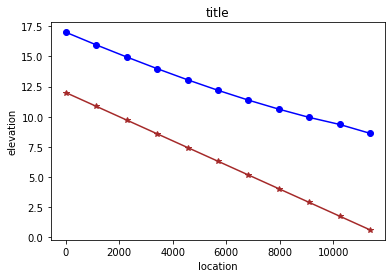

In [11]:
k = 0 # time counter
t = 0.0 # elapsed time
writenow(t,dt,y,v,b0,s) #print the start conditions
for itime in range(0,kmax): # begin time stepping loop scope
#print('Iteration Count = ',itime)
######## Adaptive Time Step Based on Current mesh courant number ###
    bestdt = dt # start with current time step
### begin courant number each cell loop scope
    for i in range(0,nn):
        a = ar(y[i],b0,s);
        b = bt(y[i],b0,s);
        c = math.sqrt(g*a/b);
        dtn = dx/abs((v[i])+c)
    # now test
        if(dtn < bestdt):
            bestdt = dtn
### end courant number each cell loop scope
    dt = bestdt
    #print('adaptive')
    #print('time-step length = ',dt)
    #writenow(t,dt,y,v,b0,s)


###### Finite Difference #################################
    r = 0.5*dt/dx;
###### LEFT BOUNDARY #####################################
# UPSTREAM FIXED STAGE AT PRESCRIBED NORMAL DEPTH        #
##########################################################
    yp[0] = yu
    ab = ar(y[1],b0,s);
    bb = bt(y[1],b0,s);
    cb = math.sqrt(g*bb/ab);
    rb = ab/wp(y[1],b0,s);
    sfb = (mn2*v[1]*v[1])/(rb**(1.333));
    cn = v[1] -cb*y[1]+ g*(s0-sfb)*dt;
    vp[0] = cn + cb*yp[0];
###### RIGHT BOUNDARY ####################################
#         FIXED STAGE AT DOWNSTREAM END                  #
##########################################################
# reflection boundary, find velocity along a characteristic
    yp[n-1] = yd ;
    aa = ar(y[n-1],b0,s);
    ba = bt(y[n-1],b0,s);
    ca = math.sqrt(g*ba/aa);
    ra = aa/wp(y[n-1],b0,s);
    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
##yp[nn] <<- (cp - vp[nn])/ca;
    vp[n] = cp - yp[n]*ca 
######## INTERIOR NODES AND REACHES ###############
### loop through the interior nodes
    for i in range(1,n): # begin interior node loop scope
        aa = ar(y[i-1],b0,s);
        ba = bt(y[i-1],b0,s);
        pa = wp(y[i-1],b0,s);
        ra = aa/pa;
        sfa = (mn2*v[i-1]*v[i-1])/(ra**(4.0/3.0));
        ab = ar(y[i+1],b0,s);
        bb = bt(y[i+1],b0,s);
        pb = wp(y[i+1],b0,s);
        rb = ab/pb;
        sfb = (mn2*v[i+1]*v[i+1])/(rb**(4.0/3.0));
# need averages of sf, hydraulic depth
        dm = 0.5*(aa/ba + ab/bb);
        sfm = 0.5*(sfa+sfb);
        vm = 0.5*(v[i-1]+v[i+1]);
        ym = 0.5*(y[i-1]+y[i+1]);
# new momentum
        vp[i] = vm -r*g*(y[i+1] - y[i-1]) -r*vm*(v[i+1] - v[i-1]) + g*dt*(s0-sfm);
# new depth
        yp[i] = ym - r*dm*(v[i+1] - v[i-1]) -r*vm*(y[i+1] - y[i-1]);
### end of interior node loop scope
# update time, count, depth and momentum
    t = t+dt; # Increment simulation time
    k = k+1; # Increment loop counter
    for i in range(0,n):
        v[i]=vp[i]
        y[i]=yp[i]
    if (k%iprt == 0): # Write current conditions every iprt time steps
        writenow(t,dt,y,v,b0,s)
    dt = 2*dt #artificially inflate the time step to force adaptive update
# end time step loop

# provisional code to make a plot - wonder if this could be put into the loop

for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","title")